In [57]:
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
from pathlib import Path

In [58]:
# Directory Variable
SAVED_MODEL_DIR = "model/saved"
CHECKPOINT_DIR = "model/checkpoint"
TRAINING_DIR = "dataset"
TESTING_DIR = "test"

In [59]:
#define processed image size
TRAIN_WIDTH = 128
TRAIN_HEIGHT = 128

def process_image(filepath, *, color=None):
    image = cv2.imread(filepath)
    if color != None:   
        image = cv2.cvtColor(image, color)
    imageRescale = cv2.resize(image, (TRAIN_WIDTH, TRAIN_HEIGHT), interpolation=cv2.INTER_AREA)
    imageRescale = imageRescale.astype(np.float64)
    imageRescale /= 255
    return imageRescale


def get_file_categories():
    train_label_mapping = {}
    for index, folder in enumerate(os.listdir(os.path.join(os.getcwd(), TRAINING_DIR))):
        train_label_mapping[index] = folder
    return train_label_mapping


def get_file():
    train_image = []
    train_filename = []
    for number, folder in enumerate(os.listdir(os.path.join(os.getcwd(), TRAINING_DIR))):
        for image_filename in os.listdir(os.path.join(os.getcwd(), TRAINING_DIR, folder)):
            # append folder name as category label
            train_filename.append(number)

            # append image to list as data source
            img_path = os.path.join(os.getcwd(), TRAINING_DIR, folder, image_filename)
            if not Path(img_path).is_file():
                continue
            
            image = process_image(img_path)
            train_image.append(image)
    return (train_image, train_filename)

        
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(TRAIN_WIDTH, TRAIN_HEIGHT, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(3))

    model.summary()

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model


def train_model(model, train_image, train_filename):
    checkpoint_path = CHECKPOINT_DIR+"/cp.ckpt"
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

    model.fit(train_image, train_filename, epochs=15, callbacks=[checkpoint_callback])
        

def test_model(model, category_map):
    images = []
    results = []

    images_RGB = []
    for images_path in os.listdir(os.path.join(os.getcwd(), TESTING_DIR)):
        if not Path(os.getcwd(), TESTING_DIR, images_path).is_file():
            continue
        
        # get image
        image = process_image(os.path.join(os.getcwd(), TESTING_DIR, images_path))
        images.append(image)
        image = np.array(image)
        
        # predict the image
        result = model.predict(np.expand_dims(image, axis=0))
        result = np.argmax(result[0])
        results.append(category_map[result])
        
        # get rgb image to display for 
        imageRGB = process_image(os.path.join(os.getcwd(), TESTING_DIR, images_path), color=cv2.COLOR_BGR2RGB)
        images_RGB.append(imageRGB)

    
    fig = plt.figure(figsize=(15,12))
    fig.suptitle('Hasil Test', fontsize=20)
    fig.patch.set_facecolor('xkcd:mint green')
    for i in range(len(images_RGB)):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_RGB[i])
        plt.xlabel(results[i])
    plt.show()

In [60]:
# Create data phase
train_image, train_filename = get_file()
train_image = np.array(train_image)
train_filename = np.array(train_filename)
print(train_filename, train_image)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2] [[[[0.0627451  0.08235294 0.09411765]
   [0.17647059 0.24705882 0.30588235]
   [0.25490196 0.32941176 0.40784314]
   ...
   [0.33333333 0.43137255 0.52156863]
   [0.21568627 0.25882353 0.34509804]
   [0.12941176 0.17254902 0.25490196]]

  [[0.04705882 0.08235294 0.11764706]
   [0.01960784 0.03921569 0.07058824]
   [0.0627451  0.09411765 0.1254902 ]
   ...
   [0.33333333 0.42352941 0.50588235]
   [0.16862745 0.2        0.29019608]
   [0.09019608 0.12941176 0.2       ]]

  [[0.07843137 0.1254902  0.16078431]
   [0.0745098  0.10588235 0.14509804]
   [0.06666667 0.09803922 0.13333333]
   ...
   [0.33333333 0.40784314 0.47843137]
   [0.09803922 0.12941176 0.21960784]
   [0.05490196 0.08235294 0.11764706]]

  ...

  [[0.22745098 0.34117647 0.43529412]
   [0.16470588 0.31372549 0.47843137]
   [0.14509804 0.23921569 0.35294118]
   ...
   [0.3254902  0.36862745 0.43529412]
   [0.14509804 0.17647059 0.28627451]
   [0.06666667 0.137254

In [61]:
# Create model phase
model = create_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_8 (Flatten)         (None, 50176)            

In [62]:
# Training model phase
train_model(model, train_image, train_filename)
model.save(SAVED_MODEL_DIR)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 1.0923 - accuracy: 0.3667
Epoch 00001: saving model to model/checkpoint\cp.ckpt
1/1 [==============================] - 1s 603ms/step - loss: 1.0923 - accuracy: 0.3667
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 1.6937 - accuracy: 0.3667
Epoch 00002: saving model to model/checkpoint\cp.ckpt
1/1 [==============================] - 0s 188ms/step - loss: 1.6937 - accuracy: 0.3667
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 1.9211 - accuracy: 0.5000
Epoch 00003: saving model to model/checkpoint\cp.ckpt
1/1 [==============================] - 0s 199ms/step - loss: 1.9211 - accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.6667
Epoch 00004: saving model to model/checkpoint\cp.ckpt
1/1 [==============================] - 0s 210ms/step - loss: 1.0788 - accuracy: 0.6667
Epoch 5/15
1/1 [==============================] - ETA: 0s - loss: 0.

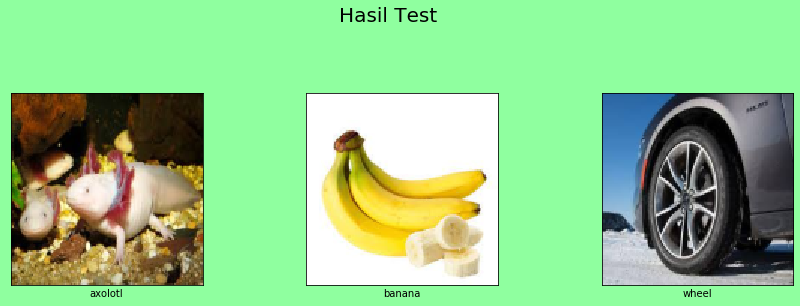

In [63]:
# Testing Phase
model.load_weights(os.path.join(os.getcwd(), CHECKPOINT_DIR+"/cp.ckpt"))
model = tf.keras.models.load_model(os.path.join(os.getcwd(), SAVED_MODEL_DIR))
test_model(model, get_file_categories())